In [1]:
dir_data = '../data/skin-cancer'
dir_ckpt = './outputs/ckpt'

seed = 0
method = 'betti-curve'
n_bins = 100

n_classes = 7
input_shape = {'img': (28, 28, 1), 'tda': (n_bins, 2)}

In [2]:
import sys
sys.path.append('../')

from cnntdanet.utils import seed_all
from cnntdanet.tda import get_tda_pipeline
from cnntdanet.models import get_cnn_net, get_cnn_tda_net
from cnntdanet.utils.plotting import plot_learning_curve
from cnntdanet.gradcam import GradCAMOnCNN, GradCAMOnCNNTDANet

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [3]:
seed_all(seed)

In [4]:
# Preparing dataset
df = pd.read_csv(os.path.join(dir_data, 'hmnist_28_28_L.csv'))

X = df.drop('label', axis=1).values.reshape((-1, *input_shape['img']))
X = X.astype(np.float32)
X /= 255.0

y = df['label'].values
y = y.astype(np.int64)

## TDA features
pipeline = get_tda_pipeline(method=method, n_bins=n_bins)

X_tda = pipeline.fit_transform(X)
X_tda = X_tda.astype(np.float32)

In [5]:
# Splitting data
y_ = y.copy()  # For stratification

train_indices, valid_indices = train_test_split(np.arange(len(X)), stratify=y_, test_size=0.2, random_state=seed)

## One-hot encoding
y = tf.keras.utils.to_categorical(y_, n_classes) 

X_img_train, X_tda_train, y_train = X[train_indices], X_tda[train_indices], y[train_indices]
X_img_valid, X_tda_valid, y_valid = X[valid_indices], X_tda[valid_indices], y[valid_indices]

In [6]:
# Build a single 2D-CNN network
cnn = get_cnn_net(input_shape=input_shape['img'], n_classes=n_classes)

# Define a loss function, an optimization method, and evaluate metrics
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

# Train the model
history = cnn.fit(
    X_img_train, y_train,
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
    epochs=20
)


Epoch 1/20


2022-11-01 16:51:33.473692: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


201/201 [==============================] - 2s 5ms/step - loss: 1.1777 - acc: 0.6634 - val_loss: 1.1114 - val_acc: 0.6862
Epoch 2/20
201/201 [==============================] - 1s 4ms/step - loss: 1.0769 - acc: 0.6653 - val_loss: 0.9645 - val_acc: 0.6862
Epoch 3/20
201/201 [==============================] - 1s 4ms/step - loss: 1.0116 - acc: 0.6663 - val_loss: 0.9271 - val_acc: 0.6918
Epoch 4/20
201/201 [==============================] - 1s 4ms/step - loss: 0.9714 - acc: 0.6762 - val_loss: 1.0555 - val_acc: 0.6818
Epoch 5/20
201/201 [==============================] - 1s 4ms/step - loss: 0.9455 - acc: 0.6770 - val_loss: 0.8938 - val_acc: 0.7093
Epoch 6/20
201/201 [==============================] - 1s 4ms/step - loss: 0.9139 - acc: 0.6833 - val_loss: 0.8461 - val_acc: 0.7112
Epoch 7/20
201/201 [==============================] - 1s 4ms/step - loss: 0.8895 - acc: 0.6912 - val_loss: 0.8320 - val_acc: 0.7162
Epoch 8/20
201/201 [==============================] - 1s 4ms/step - loss: 0.8707 - acc:

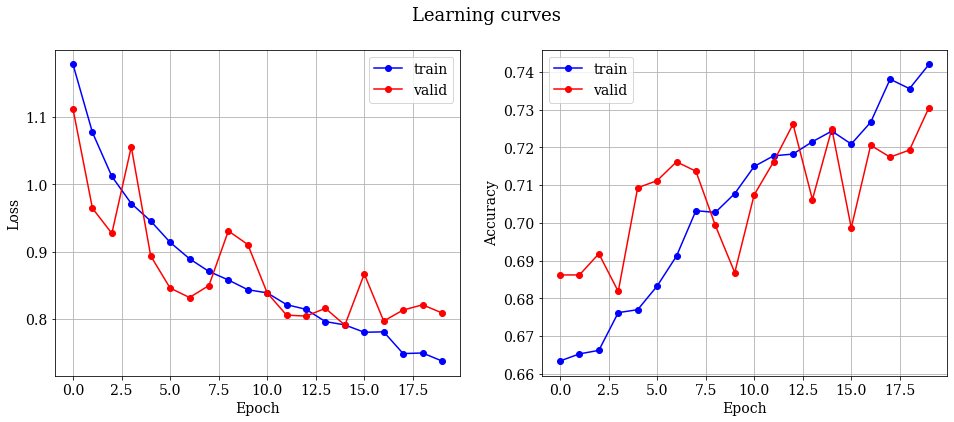

In [7]:
plot_learning_curve(history.history)

In [8]:
y_true = np.argmax(y_valid, axis=1) # From one-hot encoding to label
y_pred = cnn.predict(X_img_valid)  # Make predictions
y_pred = np.argmax(y_pred, axis=1)  # Take the maximum probability for each prediction

print(f"Accuracy  : {100 * accuracy_score(y_true, y_pred):.2f}")
print(f"Recall    : {100 * recall_score(y_true, y_pred, average='macro'):.2f}")
print(f"Precision : {100 * precision_score(y_true, y_pred, average='weighted', zero_division=0):.2f}")
print(f"F1        : {100 * f1_score(y_true, y_pred, average='weighted', zero_division=0):.2f}")

Accuracy  : 72.69
Recall    : 28.43
Precision : 67.33
F1        : 68.60


In [9]:
# Build a single 2D-CNN network
cnn_tda = get_cnn_tda_net(method=method, input_shape=input_shape, n_classes=n_classes)
# Define a loss function, an optimization method, and evaluate metrics
cnn_tda.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
# Train the model
history = cnn_tda.fit(
    [X_img_train, X_tda_train], y_train,
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
    epochs=20
)

Epoch 1/20
201/201 [==============================] - 3s 9ms/step - loss: 1.0956 - acc: 0.6625 - val_loss: 0.9842 - val_acc: 0.6706
Epoch 2/20
201/201 [==============================] - 1s 7ms/step - loss: 0.9722 - acc: 0.6705 - val_loss: 0.8909 - val_acc: 0.6925
Epoch 3/20
201/201 [==============================] - 1s 7ms/step - loss: 0.9253 - acc: 0.6795 - val_loss: 0.8655 - val_acc: 0.7043
Epoch 4/20
201/201 [==============================] - 1s 7ms/step - loss: 0.9019 - acc: 0.6878 - val_loss: 1.0078 - val_acc: 0.6956
Epoch 5/20
201/201 [==============================] - 1s 7ms/step - loss: 0.8964 - acc: 0.6915 - val_loss: 0.8516 - val_acc: 0.7087
Epoch 6/20
201/201 [==============================] - 1s 7ms/step - loss: 0.8755 - acc: 0.6942 - val_loss: 0.8675 - val_acc: 0.7143
Epoch 7/20
201/201 [==============================] - 1s 7ms/step - loss: 0.8655 - acc: 0.7007 - val_loss: 0.8347 - val_acc: 0.7130
Epoch 8/20
201/201 [==============================] - 1s 7ms/step - loss: 0.

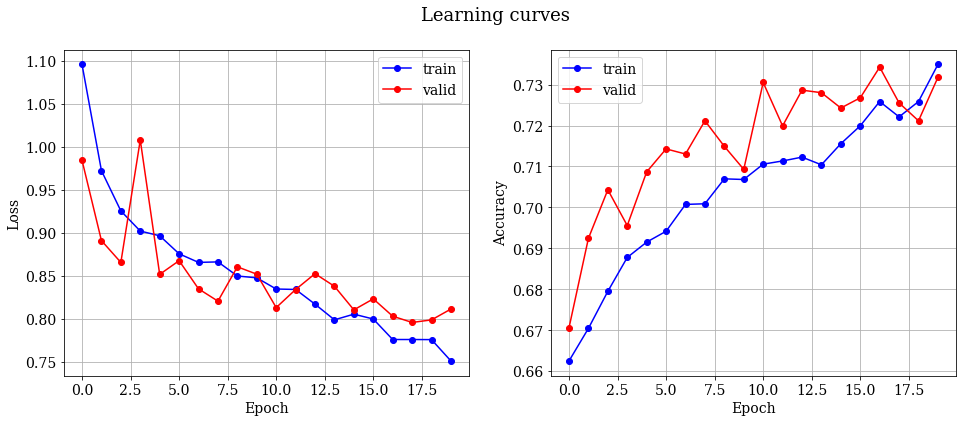

In [10]:
plot_learning_curve(history.history)

In [11]:
y_true = np.argmax(y_valid, axis=1) # From one-hot encoding to label
y_pred = cnn_tda.predict([X_img_valid, X_tda_valid])  # Make predictions
y_pred = np.argmax(y_pred, axis=1)  # Take the maximum probability for each prediction

print(f"Accuracy  : {100 * accuracy_score(y_true, y_pred):.2f}")
print(f"Recall    : {100 * recall_score(y_true, y_pred, average='macro'):.2f}")
print(f"Precision : {100 * precision_score(y_true, y_pred, average='weighted', zero_division=0):.2f}")
print(f"F1        : {100 * f1_score(y_true, y_pred, average='weighted', zero_division=0):.2f}")

Accuracy  : 72.74
Recall    : 32.44
Precision : 68.17
F1        : 69.12


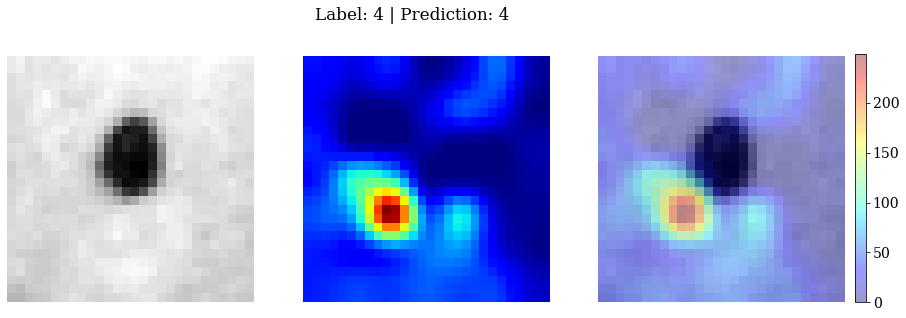

In [12]:
idx = 0
img = X_img_valid[idx:idx+1]
label = np.argmax(y_valid, axis=1)[idx]

gradcam_cnn = GradCAMOnCNN(cnn, layer_name='conv2d_3')
gradcam_cnn.to_heatmap(img, true_label=label)
gradcam_cnn.visualize()

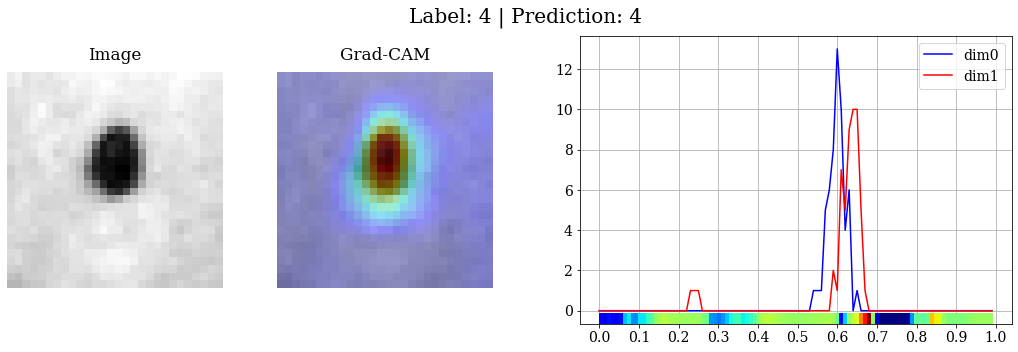

In [13]:
idx = 0
img = X_img_valid[idx:idx+1]
tda = X_tda_valid[idx:idx+1]
label = np.argmax(y_valid, axis=1)[idx]

gradcam_cnn_tda = GradCAMOnCNNTDANet(cnn_tda, local_layer_name='conv2d_8', global_layer_name='conv1d_8')
gradcam_cnn_tda.to_heatmap([img, tda], true_label=label)
gradcam_cnn_tda.visualize()

In [14]:
cnn.save(os.path.join(dir_ckpt, f'hmnist_cnn_seed{seed}_20'))
cnn_tda.save(os.path.join(dir_ckpt, f'hmnist_cnn_tda_seed{seed}_20'))

INFO:tensorflow:Assets written to: ./outputs/ckpt/hmnist_cnn_seed0/assets
INFO:tensorflow:Assets written to: ./outputs/ckpt/hmnist_cnn_tda_seed0/assets
